# Проект «Аренда самокатов»

У нас имеются данные сервиса аренды самокатов.
Данные представляют собой информацию о некоторых пользователях из нескольких городов, а также об их поездках.
Структурно данные содержатся в 3 разных файлах: пользователи, поездки, подписки.

#### Задача

Проанализировать данные и проверить некоторые гипотезы в интересах бизнеса, выводы о которых могут способствовать его росту.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from scipy import stats as st

In [2]:
pd.set_option('display.width', 300)
pd.set_option('display.max_columns', 40)

In [3]:
url = '~/Documents/DataScience/StatDataAnalysis/'

In [4]:
try:
    data_users = pd.read_csv('/datasets/users_go.csv')
except:
    data_users = pd.read_csv(url + 'users_go.csv')

In [5]:
try:
    data_rides = pd.read_csv('/datasets/rides_go.csv')
except:
    data_rides = pd.read_csv(url + 'rides_go.csv')

In [6]:
try:
    data_subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_subs = pd.read_csv(url + 'subscriptions_go.csv')

Посмотрим первые строки каждого набора данных:

In [7]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [8]:
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
data_subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Посмотрим информацию о датасетах:

In [10]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [11]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [12]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Мы видим, что таблицы полные, пропусков нет (количество непустых записей совпадает с общим количеством записей для каждой из таблиц). При этом размер таблицы data_subs очень мал, что позволяет нам просто посмотреть ее всю и вручную оценить ситуацию.


#### Возможные проблемы:
* Наличие дубликатов
* Заведомо некорректные значения в столбце subscription_type, т.к. есть ограничения в виде перечня возможных значений, указанных в таблице data_subs.
* Возможные некорректные значения в столбце даты. Это можно проверить на этапе преобразования к нужному типу данных.

### Предобработка данных

Приведем столбец "date" датасета "data_rides" к типу даты pandas:

In [13]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')

Создадим новый столбец с номером месяца из столбца "date"

In [14]:
data_rides['month_date'] = data_rides['date'].dt.month

Мы видим, что все таблицы полные, без пропусков (количество непустых записей совпадает с общим количеством записей для каждой из таблиц).
Проверим таблицы на наличие дубликатов и, если есть, удалим их. В таблице с подписками (data_subs) дубликатов, очевидно, нет (всего 2 записи в таблице, можно их посмотреть).

In [15]:
data_users.duplicated().sum()

31

In [16]:
data_users = data_users.drop_duplicates()

In [17]:
data_rides.duplicated().sum()

0

Проверим, что в столбце subscription_type нет неожиданных значений:

In [18]:
data_users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Предобработка данных выполнена. Дубликаты удалены, значения столбцов subscription_type и date оказались корректными.

### Исследовательский анализ данных

<Axes: title={'center': 'Распределение количества клиентов по городам'}, xlabel='Города', ylabel='Количество клиентов'>

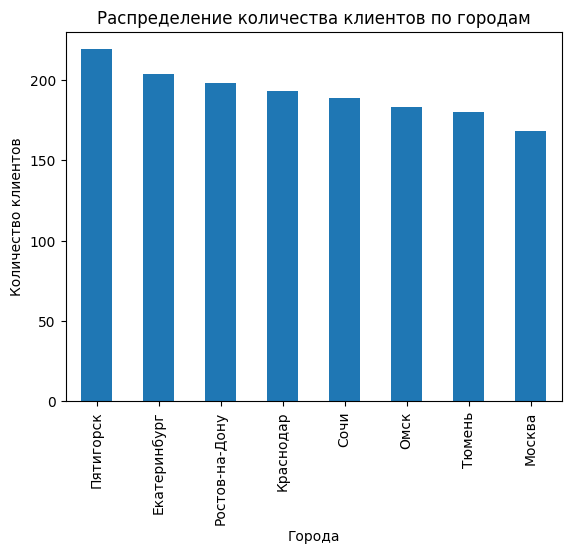

In [19]:
data_users['city'].value_counts().plot(kind='bar', xlabel='Города', ylabel='Количество клиентов', title='Распределение количества клиентов по городам')

Мы видим, что города в выборке представлены неодинаково, и разница между большинством и меньшинством пользователей из различных городов составляет:

In [20]:
'{:.1%}'.format((data_users['city'].value_counts().max() - data_users['city'].value_counts().min()) / float(data_users['city'].value_counts().min()))

'30.4%'

от числа пользователей в городе с меньшинством пользователей -- Москве.

Отобразим таблицу частотности городов:

In [21]:
t_table = pd.pivot_table(data_users, index='city', values='user_id', aggfunc=lambda col: '{:.1%}'.format(float(col.count() / len(data_users))))
t_table.columns = ['Частотность']
t_table

,Частотность
city,
Екатеринбург,13.3%
Краснодар,12.6%
Москва,11.0%
Омск,11.9%
Пятигорск,14.3%
Ростов-на-Дону,12.9%
Сочи,12.3%
Тюмень,11.7%


Мы видим, что доли городов, хоть и не одинаковы, но распределены более-менее ровно относительно потенциальной средней доли 
(100 / 8 = $12.5\%$).

Соотношение пользователей с подпиской и без:

<Axes: title={'center': 'Распределение количества пользователей по типам подписок'}, xlabel='Тип подписки', ylabel='Количество пользователей'>

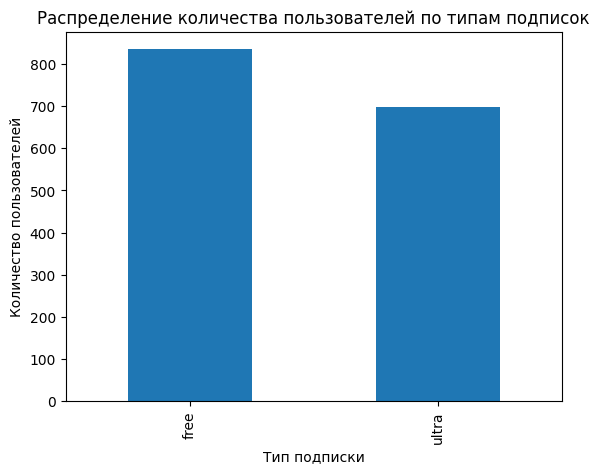

In [22]:
data_users['subscription_type'].value_counts().plot(kind='bar', xlabel='Тип подписки', ylabel='Количество пользователей', title='Распределение количества пользователей по типам подписок')

Мы видим, что в выборке количество пользователей без подписки (и абонентской платы) превышает количество пользователей-абонентов на

In [23]:
((data_users.query('subscription_type == "free"')['subscription_type'].count() - data_users.query('subscription_type == "ultra"')['subscription_type'].count()) / float(data_users['subscription_type'].count()) * 100).round(1)

8.9

процентов от общего числа клиентов

<Axes: title={'center': 'Пользователи по типам подписки в долях'}, ylabel='Доля пользователей'>

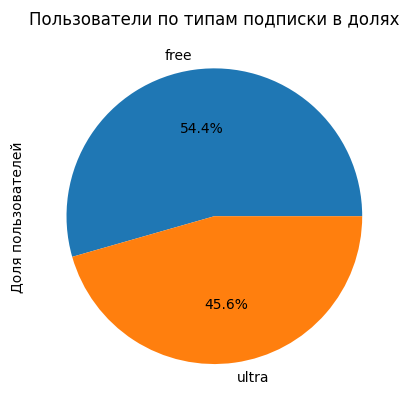

In [24]:
data_users['subscription_type'].value_counts().plot(kind='pie', ylabel='Доля пользователей', title='Пользователи по типам подписки в долях', autopct='%1.1f%%')

Мы видим, что количество пользователей с подпиской меньше чуть менее, чем на $9\%$ от общего числа пользователей.

Проанализируем возраст клиентов.

<Axes: title={'center': 'Распределение клиентов по возрастам'}, xlabel='Возраст', ylabel='Количество пользователей'>

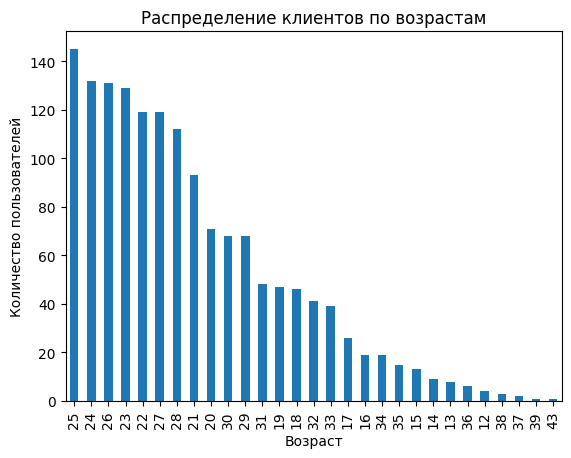

In [25]:
data_users['age'].value_counts().plot(kind='bar', xlabel='Возраст', ylabel='Количество пользователей', title='Распределение клиентов по возрастам')

Для большей наглядности посмотрим разбиение клиентов по группам возрастов:

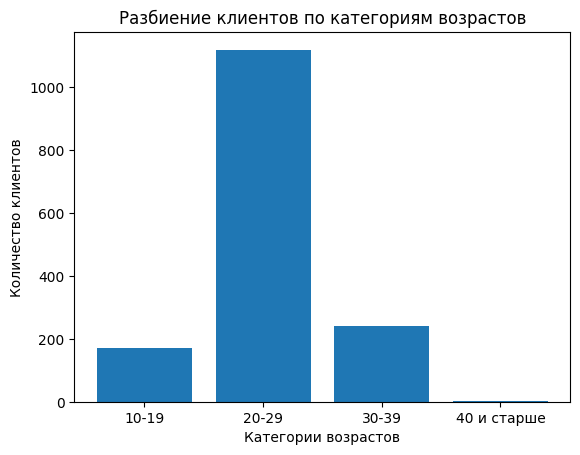

In [26]:
fig, ax = plt.subplots()
ax.set_title('Разбиение клиентов по категориям возрастов')
plt.bar(
    ['10-19', '20-29', '30-39', '40 и старше'], 
    [
        data_users.query('(age >= 10) & (age <= 19)')['age'].count(),
        data_users.query('(age >= 20) & (age <= 29)')['age'].count(),
        data_users.query('(age >= 30) & (age <= 39)')['age'].count(),
        data_users.query('(age >= 40)')['age'].count()
    ]
)
plt.xlabel("Категории возрастов")
plt.ylabel('Количество клиентов')
plt.show()

Самая многочисленная группа клиентов -- молодые 20-летние люди, что объяснимо молодостью и платежеспособностью.

Следующая группа -- 30-летние люди.
Самая малочисленная группа -- подростки и совсем молодые люди, у любителей самокатов в которой скорее будет собственный самокат, нежели
прокатный, поэтому их немного.

Группа людей старше 40 лет пренебрежимо мала.

Распределение расстояний за одну поездку:

<Axes: title={'center': 'Распределение расстояний за поездку'}, xlabel='Расстояние', ylabel='Количество поездок'>

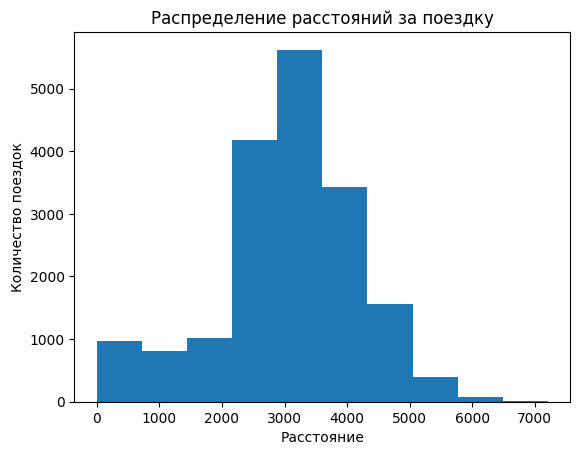

In [27]:
data_rides['distance'].plot(kind='hist', xlabel='Расстояние', ylabel='Количество поездок', title='Распределение расстояний за поездку')

Мы видим, что расстояние большинства совершаемых поездок находится в пределах от 0 км до 5 км. При этом наблюдаются пиковые значения расстояний от 2.1 км до 4.1, что может объяснятся регулярностью маршрутов клиентов (например, с работы/на работу).

<Axes: title={'center': 'Распределение времени за поездку'}, xlabel='Время поездки', ylabel='Количество поездок'>

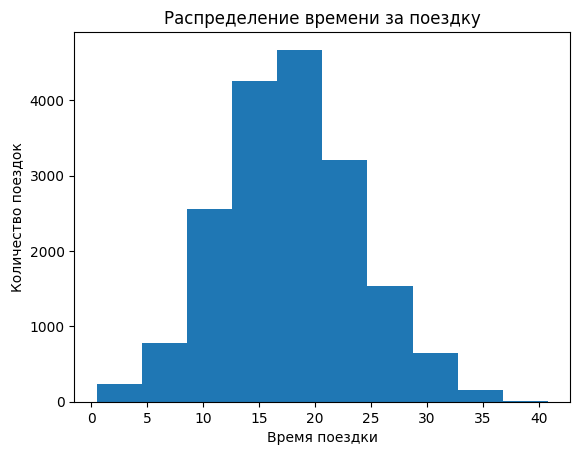

In [28]:
data_rides['duration'].plot(kind='hist', xlabel = 'Время поездки', ylabel = 'Количество поездок', title='Распределение времени за поездку')

Мы видим, что большинство совершаемых поездок имеет продолжительность от 8 до примерно 27 минут.

### Объединение данных

Объединим все таблицы в один датафрейм, опираясь сначала на поле идентификатора пользователя (user_id), а затем на тип подписки.

Для начала проверим, есть ли такие записи в data_rides, user_id которых нет в датасете пользователей

In [29]:
data_rides['user_id'].apply(lambda t: t not in data_users['user_id'].values).sum()

0

Таких записей нет.
Объединяем таблицы.

In [30]:
data = data_users.merge(data_rides, on='user_id')

In [31]:
data = data.merge(data_subs, on='subscription_type')

Выделим два новых датафрейма (с подпиской и без)

In [32]:
data_ultra_sub = data.query('subscription_type == "ultra"')

In [33]:
data_free_sub = data.query('subscription_type == "free"')

Расстояние, которое в среднем проезжают пользователи разных подписок:

<Axes: title={'center': 'Распределение расстояний за поездку среди пользователей платной подписки'}, xlabel='Расстояние', ylabel='Количество поездок'>

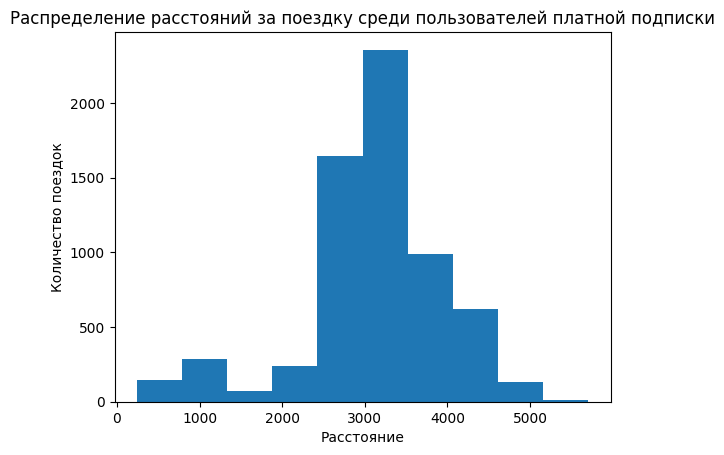

In [34]:
data_ultra_sub['distance'].plot(kind='hist', xlabel='Расстояние', ylabel='Количество поездок', title='Распределение расстояний за поездку среди пользователей платной подписки')

Мы видим, что большинство пользователей платной подписки в среднем проезжает от 2.5 до 4 км, что может объясняться регулярностью маршрута,

<Axes: title={'center': 'Распределение времени за поездку среди пользователей платной подписки'}, xlabel='Время поездки', ylabel='Количество поездок'>

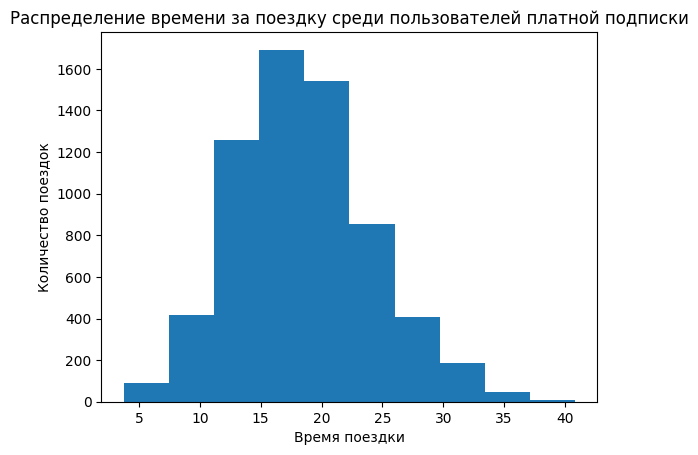

In [35]:
data_ultra_sub['duration'].plot(kind='hist', xlabel='Время поездки', ylabel='Количество поездок', title='Распределение времени за поездку среди пользователей платной подписки')

Мы видим, что большинство пользоваателей с платной подпиской тратит на поездку в среднем от 13 до 25 минут.

<Axes: title={'center': 'Распределение расстояний за поездку среди пользователей бесплатной подписки'}, xlabel='Расстояние', ylabel='Количество поездок'>

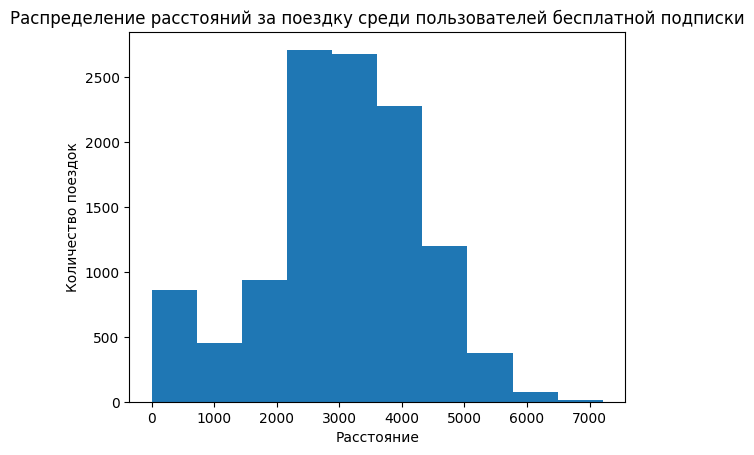

In [36]:
data_free_sub['distance'].plot(kind='hist', xlabel='Расстояние', ylabel='Количество поездок', title='Распределение расстояний за поездку среди пользователей бесплатной подписки')

Мы видим, что большинство пользователей с бесплатной подпиской в среднем проезжает от 2.1 до 5 км.
Кроме того, аидим всплеск пользователей до 1500 км, что может объяснятся желанием новых пользователей попробовать сервис.

<Axes: title={'center': 'Распределение времени за поездку среди пользователей бесплатной подписки'}, xlabel='Время поездки', ylabel='Количество поездок'>

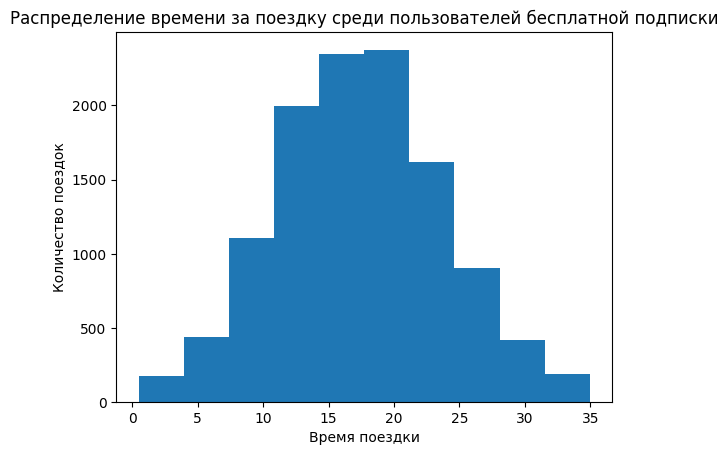

In [37]:
data_free_sub['duration'].plot(kind='hist', xlabel='Время поездки', ylabel='Количество поездок', title='Распределение времени за поездку среди пользователей бесплатной подписки')

Мы видим, что большинство пользователей бесплатной подписки тратит на поездку от 8 до 25 минут.

### Подсчет выручки

Создаем из общей таблицы (data) сводную с агрегированными данными, содержащи суммарное количество поездок, расстояние и время
для каждого пользователя за каждый месяц.

In [38]:
gr_t_data = data.groupby(['user_id', 'month_date']).aggregate({'distance': ['sum', 'count'], 'duration': lambda col: numpy.ceil(col).sum()})

Добавляем информацию с помесячной выручкой

In [39]:
def subs_info_2(ind, info_type):
    def func(x):
        return data_subs[data_subs['subscription_type'] == data_users.loc[data_users['user_id'] == x, 'subscription_type'].item()][info_type].item()

    t_df = pd.DataFrame(i[0] for i in gr_t_data.index.values).set_index(ind)
    t_df[0] = t_df[0].apply(func)

    return t_df[0]

gr_t_data['Revenue'] = gr_t_data['distance']['count'] * subs_info_2(gr_t_data.index, 'start_ride_price') + \
                        gr_t_data['duration']['<lambda>'] * subs_info_2(gr_t_data.index, 'minute_price') + \
                        subs_info_2(gr_t_data.index, 'subscription_fee')

In [40]:
gr_t_data

distance       duration Revenue
                             sum count <lambda>        
user_id month_date                                     
1       1            7027.511294     2     42.0   451.0
        4             754.159807     1      7.0   241.0
        8            6723.470560     2     46.0   475.0
        10           5809.911100     2     32.0   391.0
        11           7003.499363     3     56.0   535.0
...                          ...   ...      ...     ...
1534    6            3409.468534     2     26.0   308.0
        8            7622.453034     2     48.0   484.0
        9            4928.173852     1     23.0   234.0
        11          13350.015305     4     78.0   824.0
        12           2371.711192     1     16.0   178.0

[11331 rows x 4 columns]

### Проверка гипотез

#### Проверим гипотезу о том, тратят ли пользоваатели с подпиской больше времени на поездки.

Сформируем выборки

In [41]:
sample_ultra = data_ultra_sub['duration']

In [42]:
sample_free = data_free_sub['duration']

Эти выборки независимы, т.к. сформированы по непересекающемуся признаку.
Нам необходимо проверить одностороннюю гипотезу о том, что среднее генеральной совокупности (далее -- ГС), из которой взята выборка с пользователями c подпиской (sample_ultra), больше, чем среднее ГС, из которой взята выборка с пользователями без подписки (sample_free).

Более точно: $$H_0: \mu_1 = \mu_2 $$ $$ H_1: \mu_1 > \mu_2 $$

где $\mu_1$ -- истинное среднее ГС, из которой взята выборка с пользователями с платной подпиской, а $\mu_2$ -- истинное среднее ГС,
из которой взята выборка с пользователями с бесплатной подпиской.

Для решения этой задачи предлагается привлечь двухвыборочный t-тест для независимых выборок.

Установим уровень статистической значимости в $5\%$

In [43]:
alpha = 0.05

In [44]:
results = st.ttest_ind(sample_ultra, sample_free, alternative='greater')

In [45]:
results.pvalue

1.2804098316645618e-34

pvalue очень мал (заведомо меньше уровня значимости alpha), что говорит о том, что нулевую гипотезу (о том, что истинные средние этих двух ГС равны) следует отвергнуть в пользу альтернативной гипотезы.

Это означает, что утверждение "пользователи с подпиской проводят больше времени на поездки" заслуживает пристальное внимание.

#### Оптимальное расстояние с точки зрения износа самоката

Сформируем выборку расстояний поездок пользователей с подпиской и проверим гипотезу о том, что среднее расстояние,
которое проезжают пользователи с подпиской за одну поездку, превышает оптимальные с точки зрения износа 3130 метров

В качестве нулевой гипотезы выберем утверждение о том, что истинное среднее из ГС с выборкой

In [46]:
sample_ultra = data_ultra_sub['distance']

равно 3130:

$$ H_0: \mu = 3130 $$ $$ H_1: \mu > 3130 $$

где $\mu$ -- истинное среднее ГС, из которой взята выборка sample_ultra.

Установим уровень статистической значимости в $5\%$

In [47]:
alpha = 0.05
value = 3130

In [48]:
results = st.ttest_1samp(sample_ultra, value, alternative='greater')

In [49]:
results.pvalue

0.9195368847849785

In [50]:
results.pvalue < alpha

False

Гипотеза $H_0$ не может быть отвергнута, а, стало быть, вероятность наблюдаемого значения -- посчитанное на выборке среднее -- или еще более далекое от него в рамках предположения об истинности нулевой гипотезы о равенстве истинного среднего заданной величине достаточно велика.

Скомпрометировать нулевую гипотезу в пользу альтернативной не удалось, соответственно, статистических оснований принимать
утверждение "среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров" мы не имеем.

#### Размер помесячной выручки по месяцам

Сформируем выборки помесячных выручек от пользователей с платной подпиской и бесплатной.

In [51]:
sample_ultra = gr_t_data[subs_info_2(gr_t_data.index, 'subscription_type') == 'ultra']['Revenue']

In [52]:
sample_free = gr_t_data[subs_info_2(gr_t_data.index, 'subscription_type') == 'free']['Revenue']

In [53]:
sample_ultra_by_month = [[],[],[],[],[],[],[],[],[],[],[],[]];
sample_free_by_month = [[],[],[],[],[],[],[],[],[],[],[],[]]

for index, row in sample_ultra.items():
    sample_ultra_by_month[index[1]-1].append(row)

for index, row in sample_free.items():
    sample_free_by_month[index[1]-1].append(row)

Эти выборки для каждого из месяцев независимы, т.к. сформированы по непересекающемуся признаку.
Нам необходимо проверить одностороннюю гипотезу о том, что среднее генеральной совокупности (далее -- ГС), из которой взята выборка с пользователями c подпиской (sample_ultra), больше, чем среднее ГС, из которой взята выборка с пользователями без подписки (sample_free) для каждого из месяцев.

То есть

$$H_0: \mu_1 = \mu_2 $$ $$ H_1: \mu_1 > \mu_2 $$

где $\mu_1$ -- истинное среднее ГС, из которой взята выборка с выручкой от пользователей с платной подпиской, а $\mu_2$ -- истинное среднее ГС,
из которой взята выборка с выручкой от пользователей с бесплатной подпиской по месяцам.

Установим уровень значимости в $5\%$

In [54]:
pvalues = []

In [55]:
for i in range(0, 12):
    results = st.ttest_ind(sample_ultra_by_month[i], sample_free_by_month[i], alternative='greater')
    pvalues.append(results.pvalue)

In [56]:
pd.Series(pvalues) < 0.05

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
dtype: bool

Мы видим, что для каждого месяца нулевую гипотезу стоит отвергнуть в пользу альтернативной, то есть тезис о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем от пользователей бесплатной подписки заслуживает пристальное внимание.

Проверим теперь гипотезу без разбивки по месяцам

Сформируем выборки:

In [57]:
sample_ultra = sample_ultra.reset_index(drop=True)

In [58]:
sample_free = sample_free.reset_index(drop=True)

Эти выборки для каждого из месяцев независимы, т.к. сформированы по непересекающемуся признаку.
Нам необходимо проверить одностороннюю гипотезу о том, что среднее генеральной совокупности (далее -- ГС), из которой взята выборка с пользователями c подпиской (sample_ultra), больше, чем среднее ГС, из которой взята выборка с пользователями без подписки (sample_free) без учета месяцев.

Точнее $$H_0: \mu_1 = \mu_2 $$ $$ H_1: \mu_1 > \mu_2 $$

где $\mu_1$ -- истинное среднее ГС, из которой взята выборка с выручкой от пользователей с платной подпиской, а $\mu_2$ -- истинное среднее ГС,
из которой взята выборка с выручкой от пользователей с бесплатной подпиской без учета месяцев.

Выберем уровень значимости в $5\%$

In [59]:
alpha = 0.05

In [60]:
results = st.ttest_ind(sample_ultra, sample_free, alternative='greater')

In [61]:
results.pvalue

1.8850394384715216e-31

Мы видим, что pvalue очень мал (заведомо меньше уровня значимости alpha),-- нулевую гипотезу следует отвергнуть в пользу альтернативной.
Это означает, что утверждение "помесячная выручка пользователей с платной подпиской больше помесячной выручки пользователей с бесплатной подпиской" заслуживает пристальное внимание.

#### Обновление серверов

Если мы хотим проверить гипотезу о качестве работы сервера после обновления, то естественно предположить, что необходимо получить 2 выбори от одних и тех же пользователей до и после обновления -- рассматривать только новых пользователей бессмысленно, т.к. они не в курсе старого положения вещей.

Тем самым у нас образуются парные (зависимые) выборки.
Для корректного теста выборки необходимо нормировать по размеру (должны быть одинаковыми), отражающему, скажем, число пользователей (или иных логических, но одинаковых сущностей), а также упорядочить так, чтобы номер элемента из обеих выборок соответствовал одному и тому же пользователю (либо логической сущности).
После чего можно применить левосторонний t-тест для зависимых выборок -- ttest_rel.

### Общий вывод

Был проведен анализ данных и получены следующие результаты.

На этапе предобработки проблем практически не было.
* Столбец с датами был приведен к нужному типу данных.
* Был создан новый столбец с номером месяца на основе столбца с датами.
* Было найдено небольшое количество дубликатов и они были удалены.

Мы исследовали данные и обнаружили следующие особенности:
* Города в данных встречаются неодинаково, но доли городов распределены более-менее ровно относительно потенциальной средней доли 
(100 / 8 = $12.5\%$).
* Количество пользователей с подпиской и без примерно одинаково с разницей менее чем в $9\%$ от общего числа пользователей.
* Для анализа возраста клиентов была проведена дополнительная категоризация по группам возрастов и выяснено, что самая многочисленная группа клиентов -- молодые 20-летние люди, что объяснимо молодостью и платежеспособностью. Следующая группа клиентов -- 30-летние люди. Самая малочисленная группа -- подростки и совсем молодые люди, у любителей самокатов в которой скорее будет собственный самокат, нежели прокатный, поэтому, вероятно, их и немного. Группа людей старше 40 лет пренебрежимо мала.
* Расстояние большинства совершаемых поездок находится в пределах от 0 км до 5 км. При этом наблюдаются пиковые значения расстояний от 2.1 км до 4.1, что может объяснятся регулярностью маршрутов клиентов (например, с работы/на работу).
* Большинство совершаемых поездок имеет продолжительность от 8 до примерно 27 минут
* Большинство пользователей платной подписки проезжает от 2.5 до 4 км
* Большинство пользоваателей с платной подпиской тратит на поездку от 13 до 25 минут.
* Большинство пользователей с бесплатной подпиской проезжает от 2.1 до 5 км. Кроме того, аидим всплеск пользователей до 1500 м, что может объяснятся желанием новых пользователей попробовать сервис.
* Большинство пользователей бесплатной подписки тратит на поездку от 8 до 25 минут.


Был произведен расчет помесячной выручки для каждого пользователя.

Были проверены 3 статистические гипотезы:
* Тратят ли пользователи с подпиской больше времени на поездки. Было установлено, что утверждение о том, что пользователи с подпиской
склонны тратить больше времени на поездки, имеет под собой статистическое основание и ему должно быть уделено пристальное внимание.
* Об оптимальном расстоянии с точки зрения износа самоката. Было установлено, что статистических оснований утверждать, что среднее расстояние, которое проезжают пользователи с подпиской, превышает оптимальные с точки зрения износа 3130 м, мы не имеем.
* Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Установлено, что для каждого месяца тезис о том, что выручка от пользователей с подпиской по месяцам выше, чем от пользователей бесплатной подписки имеет статистические основания и заслуживает внимания. Была также проверена гипотеза о том, что помесячная выручка пользователей с платной подпиской выше, чем помесячная выручка от пользователей с бесплатной подпиской без учета месяцев. Установлено, что тезис "помесячня выручка пользователей с платной подпиской выше, чем помесячная выручка от пользователей с бесплатной подпиской" заслуживает пристальное внимание.

В целом, для сервиса проката рекомендуется сфокусироваться на возрастной группе 20-29 лет как основной среди клиентов сервиса, а также уделять особое внимание пользователям с подпиской, т.к. они могут быть выгоднее для компании, т.к., вероятно, тратят больше времени на поездки, а также помесячная выручка от них больше.